In [25]:
using DataFrames, CSV, PlotlyJS, JSONTables

┌ Info: Precompiling JSONTables [b9914132-a727-11e9-1322-f18e41205b0b]
└ @ Base loading.jl:1260


In [26]:
# Parse the string percentile range column into two numeric ones we can easily use
col_regex = r"p(.+)p(.+)"
function getPercentiles(ps::String)
    m = match(col_regex, ps)
    if typeof(m) == Nothing 
        return (-1.0, -1.0)
    end
    start, stop = map(s -> parse(Float64, s), m.captures)
    return (start, stop)
end
function addPercentileCols(df::DataFrame)
    percentiles = [getPercentiles(r[:percentile]) for r in eachrow(df)]
    df[!, :start] = [p[1]/100 for p in percentiles]
    df[!, :end] = [p[2]/100 for p in percentiles]
    return df
end

addPercentileCols (generic function with 1 method)

In [27]:
# Grab two tables that we care about
data = CSV.read("./data/WID_data_US.csv") |> DataFrame
# Post-tax disposable income (threshold for being in this bracket)
income = addPercentileCols(filter(r -> r[:variable] == "tcainc992j", data))
# The share of total post-tax claimed by this bracket
share = addPercentileCols(filter(r -> r[:variable] == "scainc992j", data));

In [28]:
# Functions to separate out only the percentiles that we care about for this analysis
totalShare(df) = filter(r -> r[:percentile] == "p0p100", df)
function fourTiersCheck(r::DataFrameRow)
    # Between 0 and 99 % we take every 1%
    if (r[:start] < .99) && (r[:end] - r[:start] ≈ 0.01)
        return true
    # From 99 to 99.9 % we take every 0.1%
    elseif (.99 <= r[:start] < .999) && (r[:end] - r[:start] ≈ 0.001)
        return true
    # from 99.9 to 99.99%% we take every 0.01%
    elseif (.999 <= r[:start]) && (r[:end] - r[:start] ≈ 0.0001)
        return true
    # from 99.99% to 100% we take every 0.001%
    elseif (.9999 <= r[:start]) && (r[:end] - r[:start] ≈ 0.00001)
        return true
    end
    return false
end
fourTiers(df) = filter(r -> threeTiersCheck(r), df)

fourTiers (generic function with 1 method)

In [31]:
tieredIncome = sort(fourTiers(income), [:year, :start])[:,[:year, :start, :end, :value]]
open("fourTiersIncome.json", "w") do io
    arraytable(io, tieredIncome)
end

365628

In [24]:
tieredIncome[1,:] |> Dict

ArgumentError: ArgumentError: Dict(kv): kv needs to be an iterator of tuples or pairs

In [10]:
# Test generating the initial plot
initial_df = sort(filter(r -> r[:year] == 2014, fourTiers(income)), :start)
crop = initial_df[:, [:start, :end, :value]]
crop |> CSV.write("generated/2014_income.csv")

"generated/2014_income.csv"

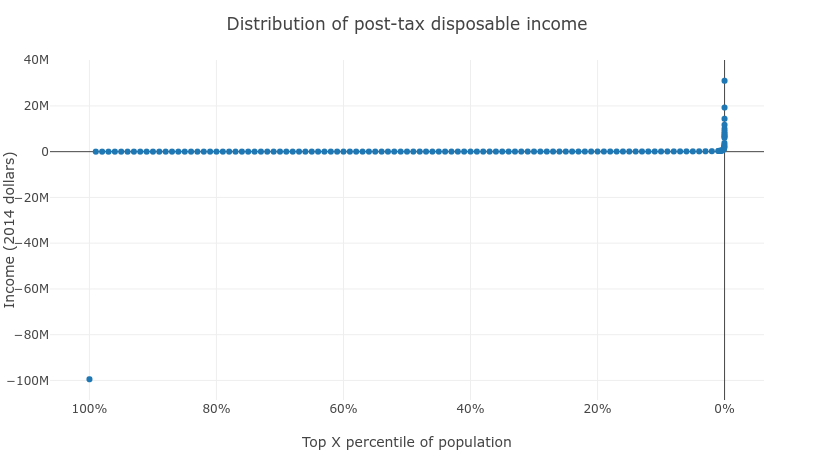

In [11]:
plot(
    scatter(
        x = [1-x for x in initial_df.start],
        y = initial_df.value,
        mode = "markers"
    ),
    Layout(
        title = "Distribution of post-tax disposable income",
        xaxis_autorange = "reversed", 
        xaxis_tickformat = ",%",
        xaxis_title = "Top X percentile of population",
        yaxis_title = "Income (2014 dollars)",
    )
)